In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam


# loading necessary libraries
import pandas as pd
import geopandas as gpd
import os
import sys
import ee
import geemap
from tqdm import tqdm
import requests
from skimage.io import imread
import matplotlib.pyplot as plt
from rasterio import plot
import rasterio as rio
import fiona
import folium
from PIL import Image
import numpy as np
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from joblib import dump, load


In [6]:
# # Trigger the authentication flow.
# ee.Authenticate()
# # Initialize the library.
# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')


# # I am using mz personal service account to authenticate the gee. If yu do not have a service account, please comment out 
# the below lines and uncomment the lines above(currently commented)
GEE_SERVICE_ACC = 'kjr-eej-jahid@ee-kazijahid.iam.gserviceaccount.com'

GEE_CREDS = "./gee_creds/ee-kazijahid-f8bb3244119c.json" 


service_account = GEE_SERVICE_ACC
credentials = ee.ServiceAccountCredentials(service_account, GEE_CREDS)
ee.Initialize(credentials, opt_url='https://earthengine-highvolume.googleapis.com')

Enter verification code: 4/1AZEOvhXQdZpOxt8BNtDXWFpww3cb0jvXL0EpDl5xHLgS1S982AeVyFvFWIA

Successfully saved authorization token.


In [7]:
# user input, please modify all your inputs here if you want to do analysis for different aoi or timeframe

# Define the study  period
# The code will analyze images only for the months within from_month to to_month for each years
from_year = 2023
to_year = 2023
from_month = 1
to_month = 12
maximum_cloud = 2 #cloud cover to filter the images in percentage
aoi_path =  "./Data/PH_Extent/Extent.shp" # location of area of interest shape file in your storage
mgrs_tile_no = '48PVT' # For the area of our interest mgrs tile no is 48PVT. For different aoi please check sentinel 2 docs


# AOI
 # the path in my local storage where the Area of interest shapefile of Chbar Ampov  is located
aoi_gpd = gpd.read_file(aoi_path) # reading the shape file as a geopandas dataframe. 
aoi_ee = geemap.shp_to_ee(aoi_path) # importing the shape file as an earth engine object


# Sentinel 2 Imagery collection

'Using sentinel 2 Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A product.Details about the productcan\
be found on the link https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED'

S2_SR_Harmonized = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterMetadata('MGRS_TILE', 'equals', '48PVT')\
    .filterBounds(aoi_ee)\
    .filter(ee.Filter.calendarRange(from_year,to_year,'year'))\
    .filter(ee.Filter.calendarRange(from_month,to_month,'month'))\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', maximum_cloud))\
    .filter(ee.Filter.lt('DARK_FEATURES_PERCENTAGE', 1))  # We are filtering the dark feature with a threshold of 1
                                                        #to reduce time we are checking the image of only on the tiles where aoi located

print("Total Sentinel2 SR Image Retrieved: ",S2_SR_Harmonized.size().getInfo())
bestCloudImage = S2_SR_Harmonized.sort('CLOUDY_PIXEL_PERCENTAGE',True).first() # Sorting the image on cloudcover and taking the best image


bestCloudImageprojection =  bestCloudImage.select('B1').projection()
bestCloudImagecrs = bestCloudImageprojection.crs()
bestCloudImagetransform_image = bestCloudImageprojection.transform()

Total Sentinel2 SR Image Retrieved:  1


In [8]:
S2_SR_Harmonized_filler = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterMetadata('MGRS_TILE', 'equals', '48PVT')\
    .filterBounds(aoi_ee)\
    .filter(ee.Filter.calendarRange(from_year,to_year,'year'))\
    .filter(ee.Filter.calendarRange(from_month,to_month,'month'))\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))\
    .filter(ee.Filter.lt('DARK_FEATURES_PERCENTAGE', 1))  # We are filtering the dark feature with a threshold of 1
                                                        #to reduce time we are checking the image of only on the tiles where aoi located
print("Total Sentinel2 SR Image Retrieved: ",S2_SR_Harmonized_filler.size().getInfo())
filler = S2_SR_Harmonized_filler.median().reproject(bestCloudImageprojection)

Total Sentinel2 SR Image Retrieved:  21


In [9]:
# Functions
def getCloudMasks(image):
    scl = image.select('SCL')
    
    #Selecting Cloudy Mask
    image_cloud_shadow = image.select('SCL').eq([3])
    image_cloud_low = image.select('SCL').eq([7])
    image_cloud_med = image.select('SCL').eq([8])
    image_cloud_high = image.select('SCL').eq([9])
    image_cloud_cirrus = image.select('SCL').eq([10])
    
    
    cloud_mask = image_cloud_shadow.add(image_cloud_low).add(image_cloud_med).add(image_cloud_high).add(image_cloud_cirrus) 

#     #Inverting the Mask
    invert_cloud_mask = cloud_mask.eq(0).selfMask().rename('NO_CLOUD_MASK') #invert mask will have the pixels with only no cloud
    cloud_mask_only = cloud_mask.eq(1).selfMask().rename('ONLY_CLOUDS_MASK') #this will have only the pixels without cloud
    
    masks = invert_cloud_mask.addBands(cloud_mask_only)
    return masks

#     image_only_clouds =  image.updateMask(cloud_mask_only).divide(10000)
#     stats = image_only_clouds.reduceRegion(reducer= ee.Reducer.sum(), geometry= aoi_ee, scale= 10)
#     print(stats.getInfo())
    
# #     img_masked = img_cloudy.updateMask(invert_mask)
# #     img_unmasked = img_masked.unmask(-1)
# #     img_cloudy_cloudless = img_unmasked

#     image_cloudless = image.updateMask(invert_cloud_mask).divide(10000)
# #     fill_image = ee.Image('COPERNICUS/S2_SR_HARMONIZED/'+fill_image_id)
# #     img_cloudy_cloudless = img_cloudy_cloudless.unmask(fill_image).divide(10000)
    
#     return image_cloudless


def cloudFIll(image, filler):
    filler = ee.Image(filler).divide(10000)
    image_filled = image.unmask(filler)
    
    return image_filled


def functn_scale_bands(image, bandstoscale, scalefactor):
    
    scaledbands = image.select(bandstoscale).multiply(scale_factor)
    
    return image.addBands(scaledbands, overwrite=True)

def functn_ResemapleSentinel2(img):
    'Function to resample the sentinel bands from there native scale to 10 meter scale. Takes the image as iput, return the resampled image'
    crs =  img.select('B1').projection().crs()
    img = img.resample('bilinear').reproject(crs=crs, scale=10)
    return img


def functn_Clip(img, aoi_ee):
    'Cliping the bands of the image to the area of interest. Takes the image and aoi feature as input and returns the clipped image.'
    clipped_img = img.clip(aoi_ee)
    return clipped_img



def functn_Ndbi(img):
    'Function to calculate ndbi for the provided image. Takes the multiband image as input, and returns a single band image \
    as output. NDBI formula is (B11 -B8)/(B11+B8). collected from https://d-nb.info/1195147821/34'
    
    ndbi = img.normalizedDifference(['B11', 'B8']).rename('NDBI')  # in sentinel 2  B11 is SWIR and B8 is NIR, 
    return ndbi

#NDWI
def functn_Ndwi(img):
    'Calculates the NDWI for. Take the multiband image as input, returns single band NDWI image.\
    NDWI formula NDWI= (Band 3 – Band 8)/(Band 3 + Band 8) is collected from doi:10.1080/01431169608948714'
    
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI') # in sentinel 2 b3 is Green and b8 is NIR
    return ndwi

# NDVI
def functn_Ndvi(img):
    'Calculates the NDVI. Takes the multiband image as input and returns single band NDVI image\
    Formula is NDVI = (B8-B4)/(B8+B4) collected from https://www.geo.fu-berlin.de/en/v/geo-it/gee/2-monitoring-ndvi-nbr/2-1-basic-information/index.html'
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI') # In Sentinel 2 B8 is NIR and B4 is Red
    return ndvi

# BSI
def functn_Bsi(img): 
    'Calculates the Baresoil index. Take the multiband image as input and returns singleband BSI image\
    The formula BSI = ((SWIR2 + RED)−(NIR + BLUE)) / ((SWIR2 + RED)+(NIR + BLUE)). Collected from Land 2021, 10(3), 231; https://doi.org/10.3390/land10030231'
    
    bsi = img.expression('( ( SWIR2 + RED ) - ( NIR + BLUE ) ) / ( ( SWIR2 + RED ) + ( NIR + BLUE))',
        {'RED': img.select('B4'),
         'SWIR2': img.select('B12'),
         'NIR': img.select('B8'),
         'BLUE': img.select('B2')}).rename('BSI')
    return bsi


In [10]:
#Generating Cloud Masks (Low, Medium, High Cloud, CLoud Shadow, Cirus)
cloudMasks = getCloudMasks(bestCloudImage) # applying the cloud mask
nocloudMask = cloudMasks.select('NO_CLOUD_MASK')
onlycloudsMask = cloudMasks.select('ONLY_CLOUDS_MASK')

#Masking the image and Scaling
bestCloudImageOnly_clouds =  bestCloudImage.updateMask(onlycloudsMask).divide(10000)
bestCloudImageCloudMasked = bestCloudImage.updateMask(nocloudMask).divide(10000)

# CloudFilling
bestCloudImageCloudMaskedCloudFilled = cloudFIll(bestCloudImageCloudMasked,filler) # filling the cloud removed pixel with
                                                                                    # median composite image
    
Map = geemap.Map()
Map.addLayer(aoi_ee, {}, 'AOI')
Map.addLayer(bestCloudImageOnly_clouds, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'Clouds')
Map.addLayer(bestCloudImageCloudMasked, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'No Clouds')
Map.addLayer(bestCloudImageCloudMaskedCloudFilled, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'Clouds Filled with filler image')
Map.centerObject(aoi_ee)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
print('Resampling the masked and scaled image')
bestCloudImageCloudMaskedCloudFilledResampled = functn_ResemapleSentinel2(bestCloudImageCloudMaskedCloudFilled) #reseampled to 10m 
print('Resampling done')


'The classification with raw sentinel 2 data did not perform well. We decide to related add the indices with the sentinel 2 \
Normalized Difference Built Up index, Water Index, Vegetation index, and Bare Soil index is considered.'
#Calculating indices
ndbi = functn_Ndbi(bestCloudImageCloudMaskedCloudFilledResampled)
ndwi = functn_Ndwi(bestCloudImageCloudMaskedCloudFilledResampled)
ndvi = functn_Ndvi(bestCloudImageCloudMaskedCloudFilledResampled)
bsi = functn_Bsi(bestCloudImageCloudMaskedCloudFilledResampled)

bestCloudImageCloudMaskedCloudFilledResampledIndices = bestCloudImageCloudMaskedCloudFilledResampled.addBands(ndbi).addBands(ndwi).addBands(ndvi).addBands(bsi)


print('Clipping the image')
bestCloudImageCloudMaskedCloudFilledResampledIndicesClipped = functn_Clip(bestCloudImageCloudMaskedCloudFilledResampledIndices,aoi_ee) #clipped to aoi
print('clipping done')

selectedbands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']+['NDBI','NDWI', 'NDVI','BSI']
bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB = bestCloudImageCloudMaskedCloudFilledResampledIndicesClipped.select(selectedbands)


Map = geemap.Map()
Map.addLayer(bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'Cloud Masked')
Map.centerObject(aoi_ee)
Map

Resampling the masked and scaled image
Resampling done
Clipping the image
clipping done


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [12]:
#Some meta info of the image that will be useful for later calculatiosn
projection_clipped =  bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB.select('B1').projection()
crs_clipped = projection_clipped.crs()
transform_image_clipped = projection_clipped.transform()

bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB_F = bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB.toFloat()

In [13]:
# import json
from io import BytesIO
# Downloading the Final bands image chunk as a NumPy structured array.
bandsData = []
failedBands = []
# selectedbands=['B1']
for band in tqdm(selectedbands):
#     print(band)
    thisBand = bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB_F.select(band)   
    
    try:
        urlNumpy = thisBand.getDownloadUrl({
            'scale': 10,
            'crs': crs_clipped,
            'region': aoi_ee.geometry(),
            'format': 'NPY'
        })
        
        responseNumpy= requests.get(urlNumpy)
        dataNumpy = np.load(io.BytesIO(responseNumpy.content), encoding='bytes').astype(np.longdouble)
        bandsData.append(dataNumpy)
    except Exception as e:
        failedBands.append(thisBand)
        print("An exception occurred while downloading band:", band)
        print(str(e))


np.save("./Data/bandsData.npy", bandsData)

bandsData = np.load("./Data/bandsData.npy")

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [07:28<00:00, 28.02s/it]


In [15]:
# Now we are importing our training data
training_dataset_gpd = gpd.read_file('./Data/TrainingData/TrainingData2.shp')
training_dataset_gpd.head()


training_dataset_gpd.columns = ['pointid_in_layer','layer_name','lclass','index', 'geometry'] # change the column name id to point_id
training_dataset_gpd['index'] = training_dataset_gpd.index #create a new column index
training_dataset_gpd['id'] = training_dataset_gpd.index #create a new column index

training_dataset_gpd.dtypes
print('Unique classes',training_dataset_gpd.lclass.unique())

# training_dataset_gpd.loc[training_dataset_gpd['lclass'] == 6, 'lclass'] = 3
training_dataset_gpd.loc[training_dataset_gpd['lclass'] == 8, 'lclass'] = 3

# transform = Affine(10.0, 0.0, 465980.0, 0.0, -10.0, 1298200.0)

# Defining the crs, and affine transform for the bounding box of the image
crs_rio = crs_clipped.getInfo()
transform_rio = rio.transform.from_origin(476280.0, 1290270.0, 10.0, 10.0)


from sklearn.utils import shuffle
training_dataset_gpd = shuffle(training_dataset_gpd).reset_index(drop=True)
training_dataset_gpd['index'] = training_dataset_gpd.index

# Extracting the spectral values from the sentinel image that was downloaded for the training points

N=len(training_dataset_gpd["id"])


spectrum_data=[] #This list will store the spectrum information at each training point.
indices_data = []


for n in tqdm(range(N)):
    point = training_dataset_gpd.iloc[n]

    row, col = rio.transform.rowcol(transform_rio, point.geometry.x, point.geometry.y)
    spectrum_data_at_xy=[]

    
    for band in bandsData:
        spectrum_data_at_xy.append(band[row,col])
    spectrum_data.append(spectrum_data_at_xy)

    
    

spectrumdata_df = pd.DataFrame(spectrum_data) # create a new dataframe with spectrum data
spectrumdata_df.columns = selectedbands # set the column names for the data frame
spectrumdata_df['index']=spectrumdata_df.index #create a column name index

final_df = pd.merge(training_dataset_gpd,spectrumdata_df, how= 'outer', on=['index'] )
final_df.to_csv('./Data/final_dataframe.csv')

Unique classes [5 6 8 0 1 2 4]


100%|████████████████████████████████████████████████████████████████████████████| 4770/4770 [00:00<00:00, 5926.18it/s]


In [16]:
final_df.head(2)

,pointid_in_layer,layer_name,lclass,index,geometry,id,B1,B2,B3,B4,...,B7,B8,B8A,B9,B11,B12,NDBI,NDWI,NDVI,BSI
0,76,SavannahGrassland,2,0,POINT (495249.703 1271395.916),3446,0.038867,0.0530,0.0660,0.0857,...,0.152262,0.1760,0.185137,0.217125,0.210537,0.146300,0.089351,-0.454545,0.345052,0.006508
1,676,RoadsAndPavements,1,1,POINT (479411.468 1266485.344),3346,0.086396,0.0772,0.0768,0.0835,...,0.146525,0.0959,0.147619,0.225969,0.190131,0.167838,0.329444,-0.110596,0.069119,0.184332


In [17]:
# Splitting the dataset into train and test data. Considering (80,20) ratio for train and test 
trainData=[]
trainLabel=[]
testData=[]
testLabel=[]
NumOfClasses=len(final_df.lclass.unique())

for i in range(NumOfClasses):
    print('Class',i)
    
    Data_class_i=final_df[final_df["lclass"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDBI','NDWI','NDVI','BSI']].values
    Labels_class_i=final_df[final_df["lclass"]==i]["lclass"]
   
    Data_train, Data_test, Label_train, Label_test = train_test_split(Data_class_i, Labels_class_i, test_size=0.2, random_state=9)
    
    print('Train,Test size : ',Data_train.shape, Data_test.shape)
    
    trainData.extend(Data_train)
    trainLabel.extend(Label_train)
    testData.extend(Data_test)
    testLabel.extend(Label_test)


trainData=np.array(trainData)
testData=np.array(testData)
trainLabel=np.array(trainLabel)
testLabel=np.array(testLabel)

Class 0
Train,Test size :  (560, 16) (140, 16)
Class 1
Train,Test size :  (560, 16) (140, 16)
Class 2
Train,Test size :  (560, 16) (140, 16)
Class 3
Train,Test size :  (560, 16) (140, 16)
Class 4
Train,Test size :  (560, 16) (140, 16)
Class 5
Train,Test size :  (560, 16) (140, 16)
Class 6
Train,Test size :  (456, 16) (114, 16)


#### SVM

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np

trainData_SVM = np.array(trainData)
testData_SVM = np.array(testData)
trainLabel_SVM = trainLabel
testLabel_SVM = testLabel

# # defining parameter distribution for random search
# param_distribution = {'C': np.logspace(-3, 3, 7),
#                       'gamma': np.logspace(-3, 3, 7),
#                       'kernel': ['poly', 'rbf']}

# # performing random search
# SVMRandom = RandomizedSearchCV(SVC(random_state=9), param_distributions=param_distribution, n_iter=5, cv=3, verbose=3)
# SVMRandom.fit(trainData_SVM, trainLabel_SVM)

# # accessing the best model and its hyperparameters
# SVMRandom_BestModel = SVMRandom.best_estimator_
# SVMRandom_BestParams = SVMRandom.best_params_

# # evaluating the best model on the test data
# accuracy = SVMRandom_BestModel.score(testData_SVM, testLabel_SVM)
# print("The classification accuracy is {:.4f}".format(accuracy))

# Saving the model
# dump(SVMRandom_BestModel, './NewModels/SVM.joblib') 

The classification accuracy is 0.9109
Classification Report for SVM
                   precision    recall  f1-score   support

           Forest       0.96      0.94      0.95       140
RoadsAndPavements       0.92      0.94      0.93       140
SavannahGrassland       0.79      0.88      0.83       140
         Building       0.95      0.95      0.95       140
            Water       0.96      0.97      0.97       140
 AgriculturalLand       0.88      0.77      0.82       140
         BareLand       0.92      0.92      0.92       114

         accuracy                           0.91       954
        macro avg       0.91      0.91      0.91       954
     weighted avg       0.91      0.91      0.91       954



Confusion Matrix for SVM


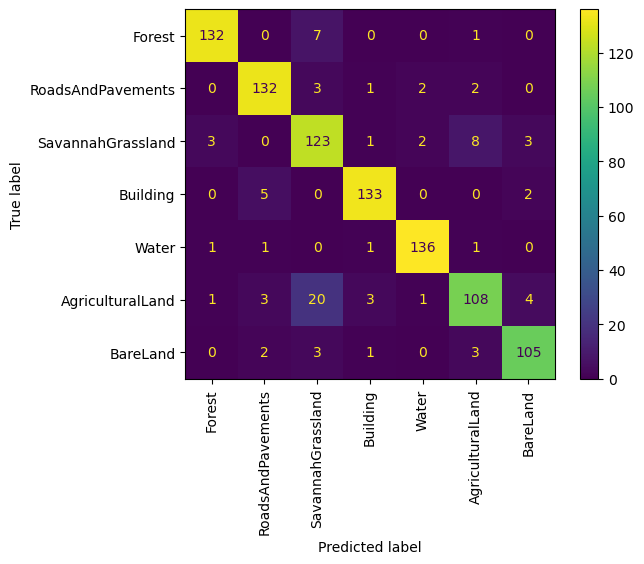

100%|██████████████████████████████████████████████████████████████████████████████| 2683/2683 [18:08<00:00,  2.47it/s]


In [30]:
SVMRandom_Reconstructed = load('./NewModels/SVM.joblib')
accuracy = SVMRandom_Reconstructed.score(testData_SVM, testLabel_SVM)
print("The classification accuracy is {:.4f}".format(accuracy))



pred_test_svm = SVMRandom_Reconstructed.predict(testData_SVM)
# Generating Classification Report
labels = ['Forest','RoadsAndPavements','SavannahGrassland','Building','Water', 
          'AgriculturalLand', 'BareLand']
print('Classification Report for SVM')
print(classification_report(testLabel_SVM, pred_test_svm, target_names=labels))

# Generating the confusion 
cm = confusion_matrix(testLabel_SVM, pred_test_svm, labels=SVMRandom_Reconstructed.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation = 90)
print('\n')
print('Confusion Matrix for SVM')
plt.show()




# Creating the classified Image array. 
# This takes time, since it is generating value for each single pixel of the classified image
predicted_LULC_SVM=[]
column_length=bandsData[0].shape[1]


for i in tqdm(range(bandsData[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(len(selectedbands)):
        spectrum_data_at_row_i.append(bandsData[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=np.transpose(SVMRandom_Reconstructed.predict(spectrum_data_at_row_i_T))
    predicted_LULC_SVM.append(predicted_class)

predicted_LULC_SVM=np.array(predicted_LULC_SVM).astype(np.uint8)

In [32]:
img_SVM=Image.fromarray(255*(predicted_LULC_SVM==2).astype(np.uint8))
img_SVM.show()

# Saving the classified image to the local storage. Please check /KMEansOutput/mlclassifiedoutputs/ in the code directory
OutputFilePath_SVM="./Data/Outputs/Classified_SVM_AfterCloudMasking.tif"
with rio.open(OutputFilePath_SVM,'w',driver='GTiff',width=bandsData[0].shape[1],height=bandsData[0].shape[0],count=1,crs=crs_rio,transform=transform_rio,dtype=np.uint8) as output:
    output.write(predicted_LULC_SVM,1)
    output.close()

#### RF

In [39]:
#Random Forest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

trainData_RF = np.array(trainData)
testData_RF = np.array(testData)
trainLabel_RF = keras.utils.to_categorical(trainLabel)
testLabel_RF = keras.utils.to_categorical(testLabel)

# # defining parameter distribution for random search
# param_distribution = {
#     'n_estimators': [200, 500, 1000, 1500, 2000],
#     'bootstrap': [True, False],
#     'min_impurity_decrease': [0.0, 0.5, 1.0],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'ccp_alpha': [0.0, 0.5, 1.0],
#     'oob_score': [True, False]
# }

# # performing random search
# RFRandomizedSearch = RandomizedSearchCV(RandomForestClassifier(random_state=9), param_distributions=param_distribution, n_iter=5, cv=5, verbose=3)
# RFRandomizedSearch.fit(trainData_RF, trainLabel_RF)

# # accessing the best model and its hyperparameters
# RFRandomizedSearch_BestModel = RFRandomizedSearch.best_estimator_
# RFRandomizedSearch_BestParams = RFRandomizedSearch.best_params_

# # evaluating the best model on the test data
# accuracy = RFRandomizedSearch_BestModel.score(testData_RF, testLabel_RF)
# print("The classification accuracy is {:.4f}".format(accuracy))

# Saving the model
# dump(RFRandomizedSearch_BestModel, './NewModels/RFT.joblib')

The classification accuracy is 0.9004
Classification Report for Random Forest Algorithm
                   precision    recall  f1-score   support

           Forest       0.74      0.94      0.82       140
RoadsAndPavements       0.95      0.89      0.92       140
SavannahGrassland       0.87      0.89      0.88       140
         Building       0.97      0.91      0.94       140
            Water       0.98      0.98      0.98       140
 AgriculturalLand       0.94      0.79      0.86       140
         BareLand       0.93      0.92      0.93       114

         accuracy                           0.90       954
        macro avg       0.91      0.90      0.90       954
     weighted avg       0.91      0.90      0.90       954



Confusion Matrix for Random Forest Algorithm


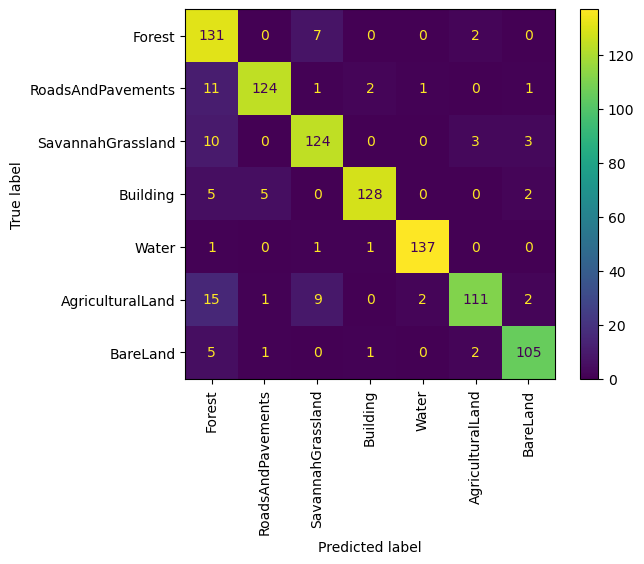

100%|██████████████████████████████████████████████████████████████████████████████| 2683/2683 [10:07<00:00,  4.42it/s]


In [41]:
RFRandomizedSearch_BestModel_Reconstructed = load('./NewModels/RFT.joblib')


accuracy = RFRandomizedSearch_BestModel_Reconstructed.score(testData_RF, testLabel_RF)
print("The classification accuracy is {:.4f}".format(accuracy))

# Generating Classification Report
pred_test_rf = np.argmax(RFRandomizedSearch_BestModel_Reconstructed.predict(testData_RF), axis=1)

print('Classification Report for Random Forest Algorithm')
print(classification_report(np.argmax(testLabel_RF, axis=1), pred_test_rf, target_names=labels)) #Cl report is based on predictions and test data
print('\n')
print('Confusion Matrix for Random Forest Algorithm')

# Generating the confusion Matrix
cm = confusion_matrix(np.array(np.argmax(testLabel_RF, axis=1)), pred_test_rf , labels=list(range(len(RFRandomizedSearch_BestModel_Reconstructed.classes_))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation = 90)
plt.show()


predicted_LULC_RF=[]
column_length=bandsData[0].shape[1]

for i in tqdm(range(bandsData[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(len(selectedbands)):
        spectrum_data_at_row_i.append(bandsData[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=RFRandomizedSearch_BestModel_Reconstructed.predict(spectrum_data_at_row_i_T)
    predicted_LULC_RF.append(np.argmax(predicted_class,axis=1))

predicted_LULC_RF=np.array(predicted_LULC_RF).astype(np.uint8)

In [42]:
img_RF=Image.fromarray(255*(predicted_LULC_RF==2).astype(np.uint8))
img_RF.show()
OutputFilePath_RF="./Data/Outputs/Classified_RF_AfterCloudMasking.tif"
with rio.open(OutputFilePath_RF,'w',driver='GTiff',width=bandsData[0].shape[1],height=bandsData[0].shape[0],count=1,crs=crs_rio,transform=transform_rio,dtype=np.uint8) as output:
    output.write(predicted_LULC_RF,1)
    output.close()

#### ANN

In [56]:
# Neural Network
from keras.callbacks import EarlyStopping

np.random.seed(9)  # set random seed to a fixed value for reproducibility

trainData_NN=np.array(trainData)
testData_NN=np.array(testData)
trainLabel_NN=keras.utils.to_categorical(trainLabel)
testLabel_NN=keras.utils.to_categorical(testLabel)


model = Sequential()
model.add(Dense(2000, activation="relu", input_dim=16))
model.add(Dropout(0.001))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.001))
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.001))
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.001))
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.001))
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.001))
model.add(Dense(250, activation="relu"))
model.add(Dropout(0.001))
model.add(Dense(250, activation="relu"))
model.add(Dropout(0.001))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.01))
model.add(Dense(7, activation="softmax"))

adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# Define early stopping callback based on training loss
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)

model.fit(trainData_NN, trainLabel_NN, epochs=200, batch_size=16, verbose=2, callbacks=[early_stopping])

loss, acc = model.evaluate(testData_NN, testLabel_NN)

print("The classification accuracy is {:.4f}".format(acc))
# model.save('./NewModels/ANN.h5')

30/30 [==============================] - 0s 8ms/step - loss: 0.2837 - accuracy: 0.9151
The classification accuracy is 0.9151
30/30 [==============================] - 0s 7ms/step
Classification Report for NN
                   precision    recall  f1-score   support

           Forest       0.95      0.89      0.92       140
RoadsAndPavements       0.94      0.94      0.94       140
SavannahGrassland       0.77      0.89      0.83       140
         Building       0.98      0.96      0.97       140
            Water       0.96      0.98      0.97       140
 AgriculturalLand       0.96      0.80      0.87       140
         BareLand       0.87      0.96      0.91       114

         accuracy                           0.92       954
        macro avg       0.92      0.92      0.92       954
     weighted avg       0.92      0.92      0.92       954



Confusion Matrix for NN


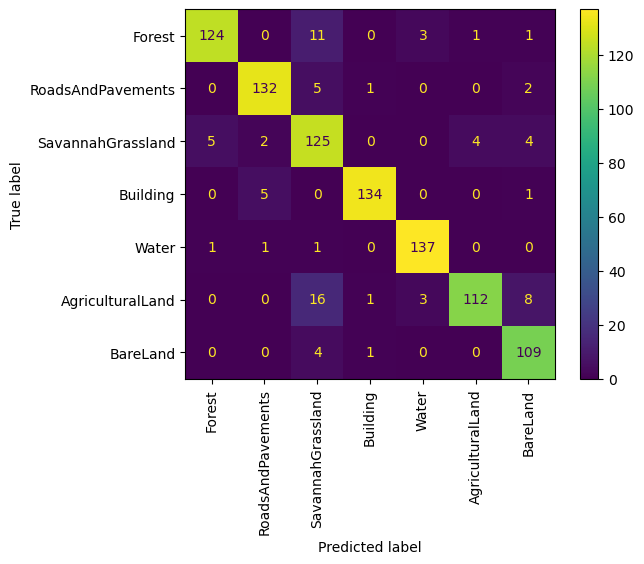

100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30982.86it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16513.01it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15951.71it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10919.11it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16328.19it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14560.40it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15921.44it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15925.22it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15846.25it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10581.66it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15794.04it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15335.66it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9920.01it/s]

27/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15891.28it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15955.51it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

27/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15974.50it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

27/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10576.65it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16085.54it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15701.65it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11669.08it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16035.57it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14962.96it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15868.73it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15898.81it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16070.13it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15459.31it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15947.92it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8003.44it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16116.44it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11158.77it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15963.10it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8003.44it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15876.24it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15887.52it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16058.59it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15921.44it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14646.19it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16077.83it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15929.00it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17260.51it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16288.56it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16292.51it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31491.72it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 12067.77it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16155.24it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16058.59it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

29/66 [============>.................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15883.75it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15445.08it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14749.20it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15978.30it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16233.40it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31595.51it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8006.31it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16116.44it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16205.96it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8065.00it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31155.46it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15982.11it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11814.94it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15768.06it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16039.40it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13291.52it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16280.66it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15940.35it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

23/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

30/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15402.54it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15902.57it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15932.78it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16043.24it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16827.70it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16039.40it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 12797.27it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31580.64it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16054.75it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30311.14it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

30/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16012.61it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15760.65it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14983.00it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15970.70it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15820.10it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

23/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

31/66 [=============>................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16054.75it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15880.00it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15864.98it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15716.36it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15887.52it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16128.06it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16012.61it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

26/66 [==========>...................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 21176.67it/s]

29/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16344.10it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15963.10it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15921.44it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17499.05it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16376.00it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

27/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

30/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13357.66it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15179.57it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16436.17it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16440.19it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 12320.33it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13510.95it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16722.87it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16328.19it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16031.74it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15989.72it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10294.35it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16066.28it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15760.65it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13571.05it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15842.51it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 29999.49it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15868.73it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8013.96it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17080.39it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16448.25it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7589.78it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15675.98it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15613.97it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

26/66 [==========>...................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10915.56it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16124.19it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14425.81it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16344.10it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16368.02it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15891.28it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11006.87it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16468.43it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16198.13it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

29/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15970.70it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16324.22it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15966.90it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16062.44it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16163.02it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14391.78it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15617.61it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13288.88it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16012.61it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16886.98it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30026.34it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

29/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11066.77it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16170.81it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7994.86it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30080.17it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31300.78it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15727.41it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10620.17it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15831.30it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

27/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16324.22it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9761.29it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15906.34it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16020.26it/s]

27/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15846.25it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15917.66it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15906.34it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16039.40it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16070.13it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15786.61it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15883.75it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15910.11it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15760.65it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16260.93it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16043.24it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16077.83it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16428.12it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

27/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10631.95it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15947.92it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11452.02it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15940.35it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15527.27it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9565.12it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15753.25it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15970.70it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16484.61it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15613.97it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16288.56it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15970.70it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15853.74it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15705.33it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10606.74it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16268.82it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15966.90it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15610.34it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15966.90it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15588.59it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16320.25it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15887.52it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

26/66 [==========>...................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16384.00it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15955.51it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15838.77it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16112.57it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16054.75it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11514.90it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15868.73it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13709.68it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15982.11it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16012.61it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16039.40it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16012.61it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15917.66it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15921.44it/s]

30/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16420.08it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15978.30it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10525.23it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16020.26it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15827.56it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15906.34it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15895.04it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31315.38it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31432.72it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15831.30it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15944.13it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16054.75it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13899.93it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15872.48it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15887.52it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15955.51it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15470.00it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8074.70it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15887.52it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15902.57it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15989.72it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16304.39it/s]

30/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16352.06it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7582.92it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15891.28it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13125.14it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15955.51it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15820.10it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17412.78it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

25/66 [==========>...................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10615.13it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16241.25it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15989.72it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15947.92it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

29/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15932.78it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31286.18it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16296.47it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15786.61it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7920.32it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10123.53it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16124.19it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15835.03it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15006.45it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9981.98it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7886.81it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15650.39it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15864.98it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7751.08it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15876.24it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8433.94it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

29/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13960.65it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16205.96it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17540.22it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10615.13it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16020.26it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8059.19it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7950.35it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16047.07it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7973.01it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 252288.96it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10435.21it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16100.98it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16093.25it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15883.75it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15917.66it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16031.74it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16066.28it/s]

 1/66 [..............................] - ETA: 2s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8050.49it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15955.51it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15902.57it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11654.89it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

24/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 12645.35it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31595.51it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10011.77it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15970.70it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16058.59it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15951.71it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16073.98it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10631.95it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16865.76it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15895.04it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16073.98it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14775.18it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10631.95it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15603.08it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15559.67it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10631.95it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16545.58it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 12406.89it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15635.80it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15929.00it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16058.59it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14745.96it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10674.23it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15982.11it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16031.74it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14797.99it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14582.54it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15723.73it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17786.61it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7657.33it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15857.48it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16328.19it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15632.16it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 6017.11it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16159.13it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15080.64it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14266.34it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

30/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15978.30it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15838.77it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9654.56it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15872.48it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10958.34it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

23/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10595.02it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13378.96it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15970.70it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11052.18it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15910.11it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16561.91it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15970.70it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31227.95it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15868.73it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16400.02it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15955.51it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15997.35it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16066.28it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15982.11it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

30/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16785.61it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13459.46it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16760.46it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16128.06it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15290.24it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

28/66 [===========>..................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7997.72it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]


66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10618.49it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14972.97it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17363.22it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15639.45it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 27136.62it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16521.14it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16012.61it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16280.66it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15963.10it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15978.30it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15742.17it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15910.11it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8456.26it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15805.20it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15756.95it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15978.30it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15868.73it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16166.91it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10513.69it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15982.11it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16586.47it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15974.50it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15932.78it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15853.74it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8071.79it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11389.83it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10628.58it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16120.31it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10606.74it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

25/66 [==========>...................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16428.12it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8093.21it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14360.98it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16300.43it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16249.12it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10540.11it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

26/66 [==========>...................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15989.72it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10623.53it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16066.28it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15959.30it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10740.86it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14033.64it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16178.61it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10209.78it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15697.98it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16081.68it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15929.00it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7981.55it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10591.68it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2903.13it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1848.02it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15887.52it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 5/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15861.23it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 5/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14707.18it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9052.86it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1102.31it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7956.00it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 1/66 [..............................] - ETA: 3s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15963.10it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15887.52it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10096.11it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 5/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1018.67it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 1/66 [..............................] - ETA: 4s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15632.16it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 5/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 5/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15857.48it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15846.25it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16436.17it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 13145.71it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15963.10it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15989.72it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15857.48it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16043.24it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15906.34it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16077.83it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14929.67it/s]

22/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8333.40it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16047.07it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31227.95it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 11810.78it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10637.00it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10372.31it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7962.61it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16070.13it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16039.40it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15679.64it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16166.91it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16093.25it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16190.32it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10264.43it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16444.22it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16001.16it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15857.48it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7973.96it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16085.54it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17655.58it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16508.95it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7627.74it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15808.92it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16631.69it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31184.42it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15764.36it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

29/66 [============>.................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15902.57it/s]

 7/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 1/66 [..............................] - ETA: 2s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15891.28it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16070.13it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15628.52it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16202.04it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

24/66 [=========>....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15902.57it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15982.11it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

26/66 [==========>...................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14116.29it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15993.53it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15880.00it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16047.07it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16004.98it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 14903.15it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16027.91it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16039.40it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16043.24it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16016.44it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16108.70it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15947.92it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15985.91it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 220752.84it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16031.74it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 6/66 [=>............................] - ETA: 0s

66/66 [==============================] - 1s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 10262.86it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15632.16it/s]

21/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

13/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15753.25it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

11/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16891.23it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

12/66 [====>.........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

17/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

16/66 [======>.......................] - ETA: 0s

66/66 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 8/66 [==>...........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15989.72it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

 9/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

10/66 [===>..........................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

20/66 [========>.....................] - ETA: 0s

66/66 [==============================] - 0s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

19/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

18/66 [=======>......................] - ETA: 0s

66/66 [==============================] - 1s 9ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16008.79it/s]

14/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

15/66 [=====>........................] - ETA: 0s

66/66 [==============================] - 1s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 2683/2683 [27:11<00:00,  1.64it/s]


In [58]:
ReconstructedModel_ANN = keras.models.load_model("./NewModels/ANN.h5")
loss,acc=ReconstructedModel_ANN.evaluate(testData_NN,testLabel_NN)
print("The classification accuracy is {:.4f}".format(acc))
pred_test_nn = np.argmax(ReconstructedModel_ANN.predict(testData_NN), axis=-1)

print('Classification Report for NN')
print(classification_report(np.argmax(testLabel_NN, axis=-1), pred_test_nn,  target_names=labels))


#Confusion Matrix for NN
cm = confusion_matrix(np.argmax(testLabel_NN, axis=-1), pred_test_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)
print('\n')
print('Confusion Matrix for NN')
plt.show()


predicted_LULC_NN=[]
column_length=bandsData[0].shape[1]

for i in tqdm(range(bandsData[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in tqdm(range(len(selectedbands))):
        spectrum_data_at_row_i.append(bandsData[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class = np.argmax(ReconstructedModel_ANN.predict(spectrum_data_at_row_i_T),axis=1 ) 
    predicted_LULC_NN.append(predicted_class)

predicted_LULC_NN=np.array(predicted_LULC_NN).astype(np.uint8)

In [59]:
#To check the classification results, this code makes the binary image of the water class.
img_NN=Image.fromarray(255*(predicted_LULC_NN==2).astype(np.uint8))
img_NN.show()

OutputFilePath_NN="./Data/Outputs/Classified_NN_AfterCloudMasking.tif"
with rio.open(OutputFilePath_NN,'w',driver='GTiff',width=bandsData[0].shape[1],height=bandsData[0].shape[0],count=1,crs=crs_rio,transform=transform_rio,dtype=np.uint8) as output:
    output.write(predicted_LULC_NN,1)
    output.close()